Simulator...
x list [2900, 2900, 2900, 2900, 2900, 2900, 2900, 2900, 2900, 2900, 2900, 2900, 2900, 2900, 2900, 2900, 2900, 2900, 2900, 2900, 2900, 2900, 2900, 2900, 2900, 2900, 2900, 2900, 2900, 2900, 2900, 2900, 2900, 2900, 2900, 2900, 2900, 2900, 2900, 2900, 2900, 2900, 2900, 2900, 2900, 2900, 2900, 2900, 2900, 2900, 2900, 2900, 2900, 2900, 2900, 2900, 2900, 2900, 2900, 2900, 2900, 2900, 2900, 2900, 2900, 2900, 2900, 2900, 2900, 2900, 2900, 2900, 2900, 2900, 2900, 2900, 2900, 2900, 2900, 2900, 2900, 2900, 2900, 2900, 2900, 2900, 2900, 2900, 2900, 2900]
Running sumo simulator
 Retrying in 1 seconds
Step #5400.00 (3ms ~= 83.33*RT, ~82000.00UPS, TraCI: 0ms, vehicles TOT 5999 ACT 246 BUF 0)tep #1125.00 (4ms ~= 62.50*RT, ~64250.00UPS, TraCI: 1ms, vehicles TOT 1081 ACT 257 BUF 0)ep #2250.00 (4ms ~= 62.50*RT, ~72500.00UPS, TraCI: 1ms, vehicles TOT 2425 ACT 290 BUF 0)p #3375.00 (5ms ~= 50.00*RT, ~59000.00UPS, TraCI: 0ms, vehicles TOT 3833 ACT 295 BUF 0) #4500.00 (4ms ~= 62.50*RT, ~62500.00UP

Step #5400.00 (6ms ~= 41.67*RT, ~72333.33UPS, TraCI: 0ms, vehicles TOT 7259 ACT 434 BUF 0)
x list [3800, 3800, 3800, 3800, 3800, 3800, 3800, 3800, 3800, 3800, 3800, 3800, 3800, 3800, 3800, 3800, 3800, 3800, 3800, 3800, 3800, 3800, 3800, 3800, 3800, 3800, 3800, 3800, 3800, 3800, 3800, 3800, 3800, 3800, 3800, 3800, 3800, 3800, 3800, 3800, 3800, 3800, 3800, 3800, 3800, 3800, 3800, 3800, 3800, 3800, 3800, 3800, 3800, 3800, 3800, 3800, 3800, 3800, 3800, 3800, 3800, 3800, 3800, 3800, 3800, 3800, 3800, 3800, 3800, 3800, 3800, 3800, 3800, 3800, 3800, 3800, 3800, 3800, 3800, 3800, 3800, 3800, 3800, 3800, 3800, 3800, 3800, 3800, 3800, 3800]
Running sumo simulator
 Retrying in 1 seconds
ep #1125.00 (5ms ~= 50.00*RT, ~67800.00UPS, TraCI: 1ms, vehicles TOT 1363 ACT 339 BUF 0)ep #2250.00 (5ms ~= 50.00*RT, ~94400.00UPS, TraCI: 1ms, vehicles TOT 2988 ACT 472 BUF 0)p #3375.00 (6ms ~= 41.67*RT, ~107833.33UPS, TraCI: 1ms, vehicles TOT 4677 ACT 647 BUF 0

Step #5400.00 (5ms ~= 50.00*RT, ~86600.00UPS, TraCI: 0ms, vehicles TOT 7349 ACT 433 BUF 0)
MAIN modx [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Validator...
       *** USING local_exploration_validator_A
       *** USING get_fit_intervals:   [[1, 6.25]]


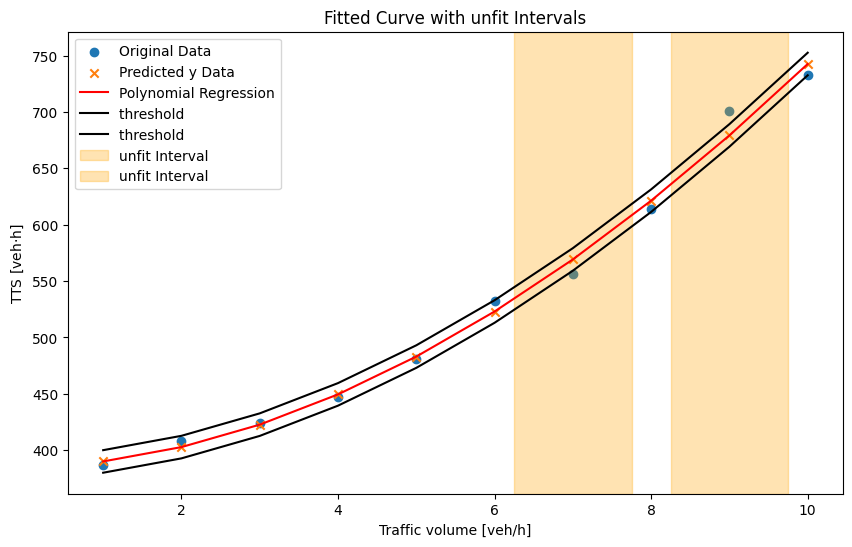

MAIN interval list from VAL: [[6.25, 7.75], [8.25, 9.75]]


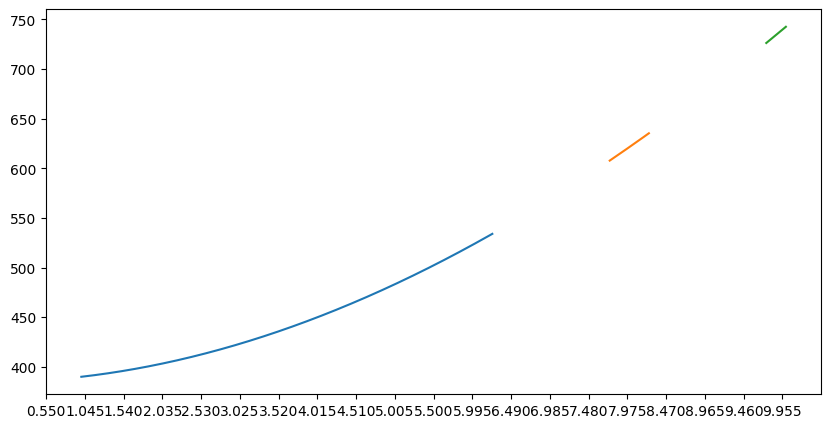

In [1]:
# IMPORT LIBRARIES
import numpy as np
import datetime

from components_configuration import components
from global_settings import simexSettings,mds

from validator_controller import ValidatorController
from modifier_controller import ModifierController
from simulator_controller import SimulatorController
from logger_utils import Logger

import pickle
import datetime
def save_object(obj, filename):
    with open(filename, 'wb') as outp:  # Overwrites any existing file.
        pickle.dump(obj, outp, pickle.HIGHEST_PROTOCOL)
        

validator_controller_novsl = ValidatorController("novsl")
logger = Logger()
logger_main_arguments = {}
is_main_func = True

# SUMO vsl
from controller_modifier_scenarios import Controller

# SUMO vsl generate modifiers [[1,[2900,...2900],[2,[3000,...3000]....]
modlist = Controller.get_list_of_modifiers(10)
# print(f"Mod list: {modlist}")
# mod_x_list = modlist

# Calls Simulator
# Input: list of ids and modifiers [[1,[2900,...2900],[2,[3000,...3000]....]
# Output: IDs,SIMULATED(values) [[1,388.88],[2,420.22]]
mod_xnv,sim_y_listnv = SimulatorController.simulator(modlist,selected_simulator=components['sumo_simulator_novsl_old'])
assert len(mod_xnv) == len(sim_y_listnv)

print("MAIN modx", mod_xnv)

# Calls Validator controller
intervals_list_novsl =  validator_controller_novsl.validate(mod_x_list=np.array(mod_xnv),sim_y_list=np.array(sim_y_listnv), selected_validator=components['validator'],global_interval=[1, 10])
print("MAIN interval list from VAL:", intervals_list_novsl)

filename1 = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
save_object(validator_controller_novsl,f"vc_novsl-{filename1}.pkl")


# MAIN cycle completed/interrupted -> write OVERALL statistics        
logger_main_arguments['log_contex'] = 'Overall Stats'                          
logger_main_arguments['main_status'] = 'end cycle'
logger.log_main(logger_main_arguments)

Modifier...
[MODC]: intervals list:  [[2500, 4000]]
[MODC]: (interval_min_tick, interval_max_tick):  (2500, 4000)
[MODC]: mod_ticks:  [2600, 2700, 2800, 2900, 3000, 3100, 3200, 3300, 3400, 3500, 3600, 3700, 3800, 3900]
[MODC]: mod_x:  [2600.0, 2681.5384615384614, 2766.153846153846, 2853.846153846154, 2944.6153846153848, 3038.4615384615386, 3135.3846153846152, 3235.3846153846152, 3338.4615384615386, 3444.6153846153848, 3553.846153846154, 3666.153846153846, 3781.5384615384614, 3900.0]
MAIN mod outcome ([[2600.0, 2681.5384615384614, 2766.153846153846, 2853.846153846154, 2944.6153846153848, 3038.4615384615386, 3135.3846153846152, 3235.3846153846152, 3338.4615384615386, 3444.6153846153848, 3553.846153846154, 3666.153846153846, 3781.5384615384614, 3900.0]], [[2500, 4000]])
Simulator...
[[2600.0, 2681.5384615384614, 2766.153846153846, 2853.846153846154, 2944.6153846153848, 3038.4615384615386, 3135.3846153846152, 3235.3846153846152, 3338.4615384615386, 3444.6153846153848, 3553.846153846154, 36

Step #5400.00 (7ms ~= 35.71*RT, ~62285.71UPS, TraCI: 0ms, vehicles TOT 7349 ACT 436 BUF 0)
x list [3900.0, 3900.0, 3900.0, 3900.0, 3900.0, 3900.0, 3900.0, 3900.0, 3900.0, 3900.0, 3900.0, 3900.0, 3900.0, 3900.0, 3900.0, 3900.0, 3900.0, 3900.0, 3900.0, 3900.0, 3900.0, 3900.0, 3900.0, 3900.0, 3900.0, 3900.0, 3900.0, 3900.0, 3900.0, 3900.0, 3900.0, 3900.0, 3900.0, 3900.0, 3900.0, 3900.0, 3900.0, 3900.0, 3900.0, 3900.0, 3900.0, 3900.0, 3900.0, 3900.0, 3900.0, 3900.0, 3900.0, 3900.0, 3900.0, 3900.0, 3900.0, 3900.0, 3900.0, 3900.0, 3900.0, 3900.0, 3900.0, 3900.0, 3900.0, 3900.0, 3900.0, 3900.0, 3900.0, 3900.0, 3900.0, 3900.0, 3900.0, 3900.0, 3900.0, 3900.0, 3900.0, 3900.0, 3900.0, 3900.0, 3900.0, 3900.0, 3900.0, 3900.0, 3900.0, 3900.0, 3900.0, 3900.0, 3900.0, 3900.0, 3900.0, 3900.0, 3900.0, 3900.0, 3900.0, 3900.0]
Running sumo simulator
 Retrying in 1 seconds
ep #1125.00 (5ms ~= 50.00*RT, ~70200.00UPS, TraCI: 1ms, vehicles TOT 1400 ACT 351 BUF 0)ep #2250.00 (6ms ~= 41.67*RT, ~83000.00UPS, Tra

Step #5400.00 (6ms ~= 41.67*RT, ~76833.33UPS, TraCI: 1ms, vehicles TOT 7529 ACT 461 BUF 0)
MODX [2600.0, 2681.5384615384614, 2766.153846153846, 2853.846153846154, 2944.6153846153848, 3038.4615384615386, 3135.3846153846152, 3235.3846153846152, 3338.4615384615386, 3444.6153846153848, 3553.846153846154, 3666.153846153846, 3781.5384615384614, 3900.0] and sim_y_list [346.1388888888888, 362.6805555555555, 372.5, 391.3055555555557, 396.61111111111103, 418.1666666666667, 425.0833333333333, 444.5, 481.09722222222234, 514.3055555555554, 595.3333333333331, 655.1527777777777, 720.3333333333335, 769.7777777777777]
MAIN modx [2600.0, 2681.5384615384614, 2766.153846153846, 2853.846153846154, 2944.6153846153848, 3038.4615384615386, 3135.3846153846152, 3235.3846153846152, 3338.4615384615386, 3444.6153846153848, 3553.846153846154, 3666.153846153846, 3781.5384615384614, 3900.0]
Validator...
       *** USING local_exploration_validator_A
       *** USING get_fit_intervals:   [[2500, 3359.6923076923076]]


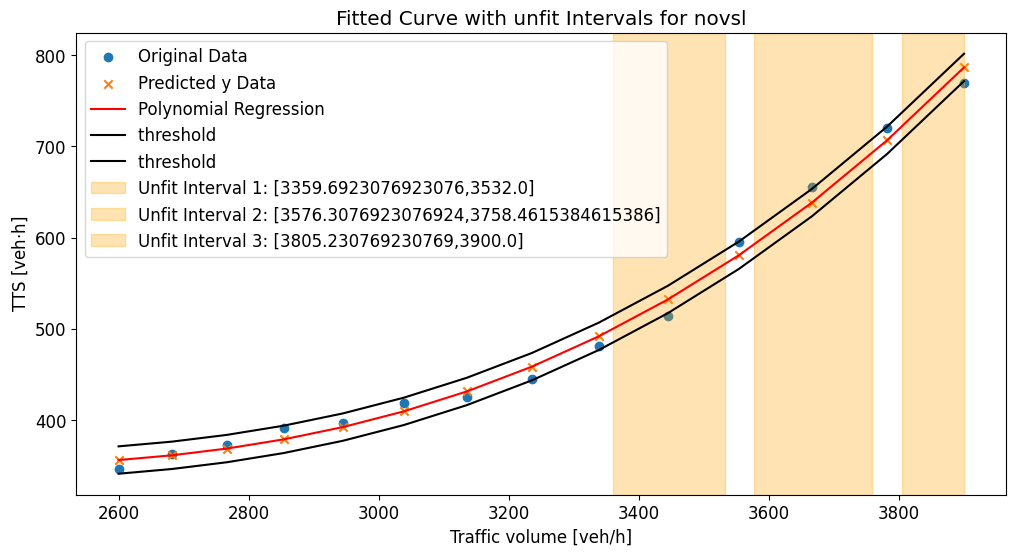

MAIN interval list from VAL: [[3359.6923076923076, 3532.0], [3576.3076923076924, 3758.4615384615386], [3805.230769230769, 3900.0]]
Modifier...
[MODC]: intervals list:  [[3359.6923076923076, 3532.0], [3576.3076923076924, 3758.4615384615386], [3805.230769230769, 3900.0]]
[MODC]: (interval_min_tick, interval_max_tick):  (3359.6923076923076, 3532.0)
[MODC]: mod_ticks:  [3400, 3475]
[MODC]: mod_x:  [3400.0, 3475.0]
[MODC]: (interval_min_tick, interval_max_tick):  (3576.3076923076924, 3758.4615384615386)
[MODC]: mod_ticks:  [3625, 3700]
[MODC]: mod_x:  [3625.0, 3700.0]
[MODC]: (interval_min_tick, interval_max_tick):  (3805.230769230769, 3900.0)
[MODC]: mod_ticks:  [3850]
[MODC]: mod_x:  [3850]
MAIN mod outcome ([[3400.0, 3475.0], [3625.0, 3700.0], [3850]], [[3359.6923076923076, 3532.0], [3576.3076923076924, 3758.4615384615386], [3805.230769230769, 3900.0]])
Simulator...
[[3400.0, 3475.0], [3625.0, 3700.0], [3850]]
 IN SIMULATE: [[3400.0, 3475.0], [3625.0, 3700.0], [3850]]
Flatten mod_x [3400

Step #5400.00 (4ms ~= 62.50*RT, ~108500.00UPS, TraCI: 0ms, vehicles TOT 7259 ACT 434 BUF 0
x list [3850, 3850, 3850, 3850, 3850, 3850, 3850, 3850, 3850, 3850, 3850, 3850, 3850, 3850, 3850, 3850, 3850, 3850, 3850, 3850, 3850, 3850, 3850, 3850, 3850, 3850, 3850, 3850, 3850, 3850, 3850, 3850, 3850, 3850, 3850, 3850, 3850, 3850, 3850, 3850, 3850, 3850, 3850, 3850, 3850, 3850, 3850, 3850, 3850, 3850, 3850, 3850, 3850, 3850, 3850, 3850, 3850, 3850, 3850, 3850, 3850, 3850, 3850, 3850, 3850, 3850, 3850, 3850, 3850, 3850, 3850, 3850, 3850, 3850, 3850, 3850, 3850, 3850, 3850, 3850, 3850, 3850, 3850, 3850, 3850, 3850, 3850, 3850, 3850, 3850]
Running sumo simulator
 Retrying in 1 seconds
Step #3350.00 (5ms ~= 50.00*RT, ~135000.00UPS, TraCI: 1ms, vehicles TOT 4695 ACT 675 BUF 0tep #1125.00 (3ms ~= 83.33*RT, ~115333.33UPS, TraCI: 1ms, vehicles TOT 1381 ACT 346 BUF 0ep #2250.00 (4ms ~= 62.50*RT, ~120250.00UPS, TraCI: 1ms, vehicles TOT 3025 ACT 481 BUF 0

Step #5400.00 (4ms ~= 62.50*RT, ~116750.00UPS, TraCI: 0ms, vehicles TOT 7439 ACT 467 BUF 0
MODX [3400.0, 3475.0, 3625.0, 3700.0, 3850] and sim_y_list [532.4027777777778, 538.1111111111113, 618.4166666666671, 701.0416666666665, 763.9722222222222]
MAIN modx [3400.0, 3475.0, 3625.0, 3700.0, 3850]
Validator...
What are POINTS  [[3400.0, 532.4027777777778], [3475.0, 538.1111111111113], [3625.0, 618.4166666666671], [3700.0, 701.0416666666665], [3850.0, 763.9722222222222], [3444.6153846153848, 514.3055555555554], [3666.153846153846, 655.1527777777777], [3900.0, 769.7777777777777]]
       *** USING local_exploration_validator_A


/home/amy/tmp/repos/SimEx/notebooks/validator.py:43: RankWarning: Polyfit may be poorly conditioned
  current_coeff = np.polyfit(x_values, y_values, deg=degree)
/home/amy/tmp/repos/SimEx/notebooks/validator.py:43: RankWarning: Polyfit may be poorly conditioned
  current_coeff = np.polyfit(x_values, y_values, deg=degree)
/home/amy/tmp/repos/SimEx/notebooks/validator.py:43: RankWarning: Polyfit may be poorly conditioned
  current_coeff = np.polyfit(x_values, y_values, deg=degree)
/home/amy/tmp/repos/SimEx/notebooks/validator.py:43: RankWarning: Polyfit may be poorly conditioned
  current_coeff = np.polyfit(x_values, y_values, deg=degree)
/home/amy/tmp/repos/SimEx/notebooks/validator.py:43: RankWarning: Polyfit may be poorly conditioned
  current_coeff = np.polyfit(x_values, y_values, deg=degree)


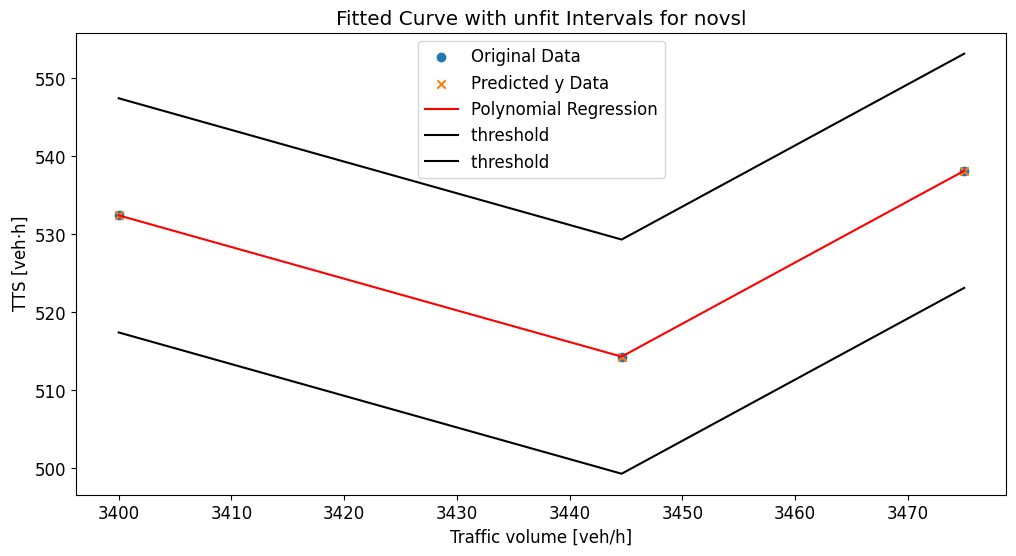

equation,
 y =  1.3443208198226033e-17x^6 + 6.167965995956142e-17x^5  -9.531647546708423e-11x^4  -4.374572566426081e-07x^3  -0.0011255736007471362x^2 + 0.038606724560384165x^1 + 22548.92270511722 
unfit_points
 [(3400.0, 532.4027777777778), (3444.6153846153848, 514.3055555555554), (3475.0, 538.1111111111113)] 
local_unfit_interval
, [[3359.6923076923076, 3532.0]]
       *** USING local_exploration_validator_A


/home/amy/tmp/repos/SimEx/notebooks/validator.py:43: RankWarning: Polyfit may be poorly conditioned
  current_coeff = np.polyfit(x_values, y_values, deg=degree)
/home/amy/tmp/repos/SimEx/notebooks/validator.py:43: RankWarning: Polyfit may be poorly conditioned
  current_coeff = np.polyfit(x_values, y_values, deg=degree)
/home/amy/tmp/repos/SimEx/notebooks/validator.py:43: RankWarning: Polyfit may be poorly conditioned
  current_coeff = np.polyfit(x_values, y_values, deg=degree)
/home/amy/tmp/repos/SimEx/notebooks/validator.py:43: RankWarning: Polyfit may be poorly conditioned
  current_coeff = np.polyfit(x_values, y_values, deg=degree)
/home/amy/tmp/repos/SimEx/notebooks/validator.py:43: RankWarning: Polyfit may be poorly conditioned
  current_coeff = np.polyfit(x_values, y_values, deg=degree)


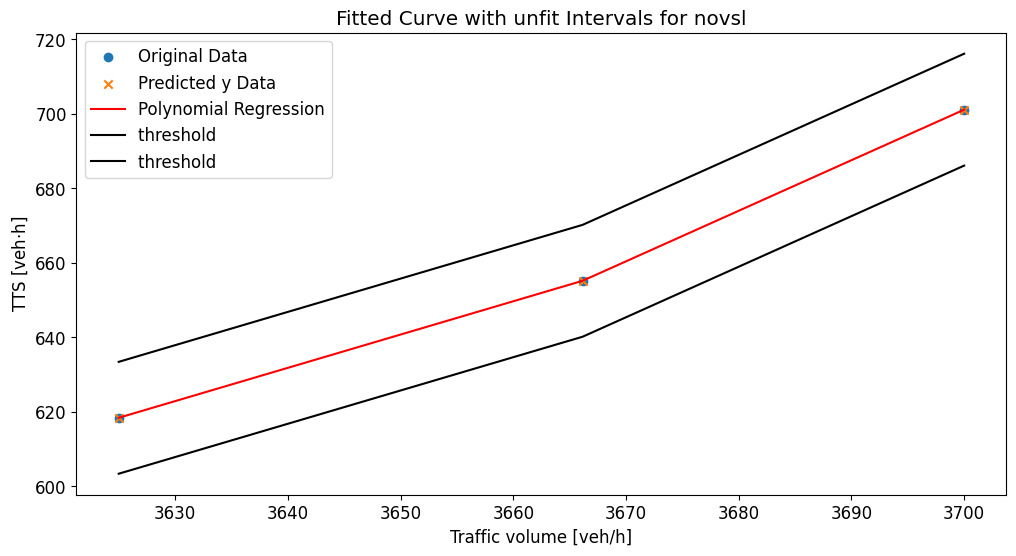

equation,
 y =  3.7868176155596236e-18x^6 + 3.8748315422164954e-16x^5  -2.8482029354711674e-11x^4  -1.420856691811935e-07x^3  -0.0003948558110328375x^2  -0.017428854058734965x^1 + 8721.526628350666 
unfit_points
 [(3625.0, 618.4166666666671), (3666.153846153846, 655.1527777777777), (3700.0, 701.0416666666665)] 
local_unfit_interval
, [[3576.3076923076924, 3758.4615384615386]]
       *** USING local_exploration_validator_A


/home/amy/tmp/repos/SimEx/notebooks/validator.py:43: RankWarning: Polyfit may be poorly conditioned
  current_coeff = np.polyfit(x_values, y_values, deg=degree)
/home/amy/tmp/repos/SimEx/notebooks/validator.py:43: RankWarning: Polyfit may be poorly conditioned
  current_coeff = np.polyfit(x_values, y_values, deg=degree)


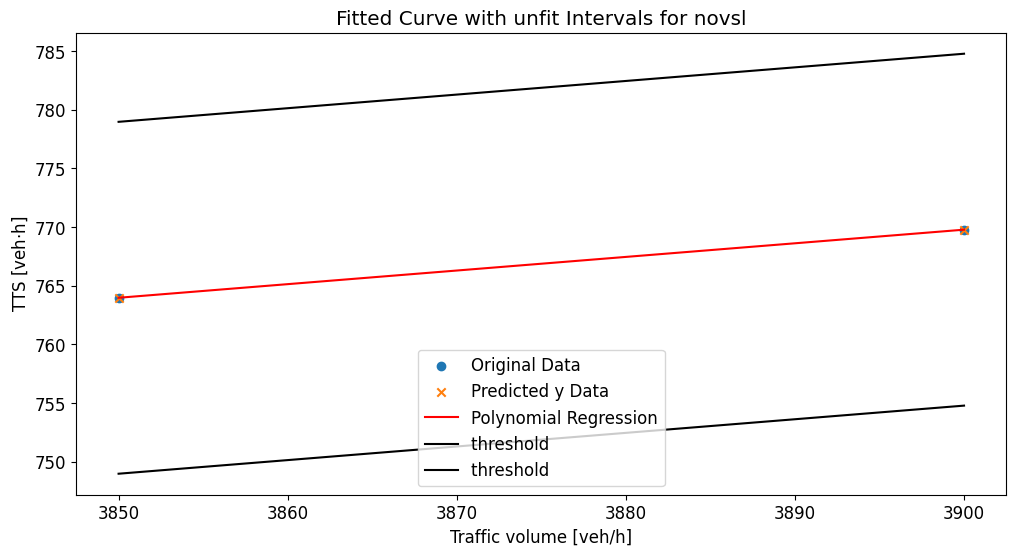

equation,
 y =  6.47031522416971e-06x^2 + 0.06596616812379129x^1 + 414.0962275353707 
unfit_points
 [(3850.0, 763.9722222222222), (3900.0, 769.7777777777777)] 
local_unfit_interval
, [[3805.230769230769, 3900.0]]
DIFFERENCES 
each_interval  [3805.230769230769, 3900.0] 
new_unfit_interval   []
MAIN interval list from VAL: []


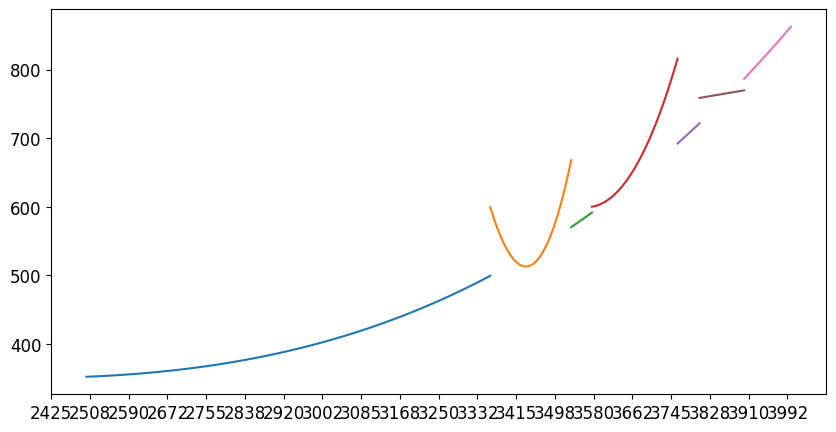

In [1]:
# IMPORT LIBRARIES
import numpy as np

from components_configuration import components
from global_settings import simexSettings,mds

from validator_controller import ValidatorController
from modifier_controller import ModifierController
from simulator_controller import SimulatorController
from logger_utils import Logger

import pickle
import datetime
def save_object(obj, filename):
    with open(filename, 'wb') as outp:  # Overwrites any existing file.
        pickle.dump(obj, outp, pickle.HIGHEST_PROTOCOL)

validator_controller_novsl = ValidatorController("novsl")
logger = Logger()
logger_main_arguments = {}
is_main_func = True
# Initialize interval list for the first iteration
intervals_list=[[mds['domain_min_interval'], mds['domain_max_interval']]]
#intervals_list=[[2900, 3200]]
# Values for the timestamp of the pickle file
count = 0
filename1 = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

while is_main_func:
    
    # Calls Modifier Controller
    mod_outcome = ModifierController.control(intervals_list=intervals_list,selected_modifier=components['modifierA'], do_plot=simexSettings['do_plot'])
    mod_x_list = mod_outcome[0]
    checked_intervals = mod_outcome[1]
    print("MAIN mod outcome", mod_outcome)  

    
    # breaks loop if iterations end by granularity reached
    if not mod_x_list: # FALSE IF ['modifier_data_point'] < mdv['modifier_incremental_unit']:
        logger_main_arguments['log_contex'] = 'overall MAIN stats'
        logger_main_arguments['main_status'] = 'no generated points'
        logger_main_arguments['remaining_unfit_intervals'] = checked_intervals
        logger.log_main(logger_main_arguments)
        break
    
    # Calls Simulator
    mod_x,sim_y_list = SimulatorController.simulate(mod_x_list,selected_simulator=components['sumo_simulator_novsl'])
    print(f"MODX {mod_x} and sim_y_list {sim_y_list}")
    assert len(mod_x) == len(sim_y_list)

    print("MAIN modx", mod_x)  

    # Calls Validator controller
    intervals_list =  validator_controller_novsl.validate(mod_x_list=np.array(mod_x),sim_y_list=np.array(sim_y_list), selected_validator=components['validator'],global_interval=[mds["domain_min_interval"], mds["domain_max_interval"]])
    print("MAIN interval list from VAL:", intervals_list)
    # Loop number (loop-1,loop2..etc)
    count +=1
    save_object(validator_controller_novsl,f"vc_novsl_loop-{count}-{filename1}.pkl")
    
    # Updates interval_list to new range output from validator controller
    # No more unfit intervals -> write MAIN log
    if not intervals_list:
        is_main_func = False
        logger_main_arguments['log_contex'] = 'overall MAIN stats'
        logger_main_arguments['main_status'] = 'no unfit intervals'
        logger.log_main(logger_main_arguments)

# MAIN cycle completed/interrupted -> write OVERALL statistics        
logger_main_arguments['log_contex'] = 'Overall Stats'                          
logger_main_arguments['main_status'] = 'end cycle'
logger.log_main(logger_main_arguments)


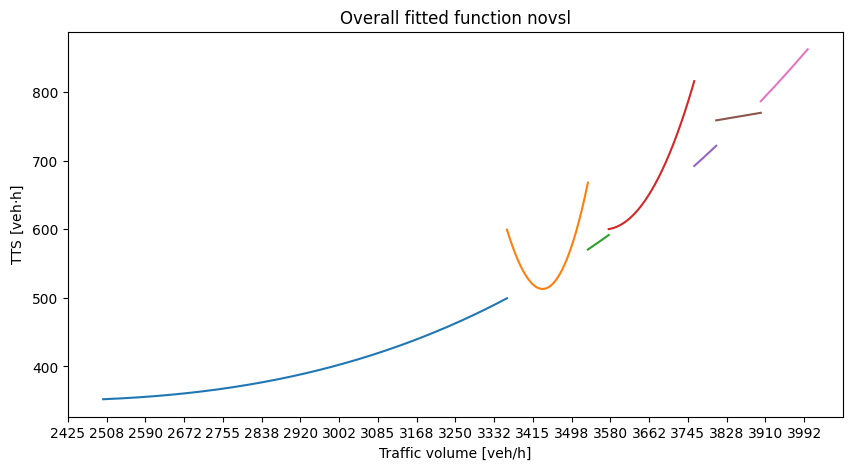

In [12]:
import re
from datetime import datetime

import matplotlib.pyplot as plt
import numpy as np
from global_settings import lgs, mgs


all_fit_intervals_data = logger.all_fit_intervals_data
remaining_unfit_intervals = logger.remaining_unfit_intervals
_, ax = plt.subplots(figsize=(10, 5))

# Plot FI intervals with their fitting functions
for element in all_fit_intervals_data:
    interval = element['interval']
    fitting_function_str = element['fitting_function']

    # Convert the string into a function
    terms = re.findall(
        r'([+-]?\s*\d+\.?\d*(?:e[+-]?\d+)?)(x\^\d+)?', fitting_function_str.replace(' ', ''))
    coefficients = [0] * 10  # Initialize a list of 10 zeros
    for term in terms:
        coef = float(term[0])
        if term[1]:  # If there is an 'x' term
            exponent = int(term[1][2:])  # Get the exponent
            while len(coefficients) <= exponent:  # Expand the list if needed
                coefficients.append(0)
            # Assign the coefficient to the corresponding position in the list
            coefficients[exponent] = coef
        else:  # If there is no 'x' term, it's the constant term
            coefficients[0] = coef
    # Reverse the list to match the order expected by np.poly1d
    fitting_function = np.poly1d(coefficients[::-1])

    # Adjust the number of points as needed
    x = np.linspace(interval[0], interval[1], 400)
    y = fitting_function(x)
    ax.plot(x, y, label=f'Interval: {interval}')
    #plt.ylim([-100, 100])
    ax.set_xticks(np.arange(*ax.get_xlim(),
                            (ax.get_xlim()[1] - ax.get_xlim()[0]) / 20))

for element in remaining_unfit_intervals:
    ax.axvspan(*element['interval'], color='gray',
               alpha=0.3, label='unfit Interval')
plt.title("Overall fitted function novsl")
plt.xlabel('Traffic volume [veh/h]')
plt.ylabel('TTS [veh$\cdot$h]')
plt.savefig(f"total_function-novsl.pdf", format='pdf')

In [13]:
save_object(logger.all_fit_intervals_data,"logger-novsl.pkl")

In [ ]:
vsl